In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [9]:
# Load the dataset
df = pd.read_csv('../ready_data/winter_2021.csv')
# Rename time dimension to "ds" and target variable to "y". This is COMPULSORY
df.rename({"ts": "ds",
           "Friction": "y"}, axis=1, inplace=True, copy=False)
df

,ds,airTemp,humidity,dewpoint,precipitation,y,Road_Surface_Temperature,Water_Film_Surface_mm
0,2021-11-01 00:00:00,8.8,94.0,7.9,0.0,0.820000,5.082435,0.000000
1,2021-11-01 00:10:00,9.1,91.0,7.7,0.0,0.820000,5.035252,0.000000
2,2021-11-01 00:20:00,9.1,90.0,7.5,0.0,0.820000,4.951386,0.000000
3,2021-11-01 00:30:00,9.2,88.0,7.3,0.0,0.820000,5.077870,0.000000
4,2021-11-01 00:40:00,9.2,86.0,7.0,0.0,0.820000,4.919721,0.000000
...,...,...,...,...,...,...,...,...
21739,2022-03-31 23:10:00,-3.9,87.0,-5.7,0.0,0.654679,-1.372575,0.045876
21740,2022-03-31 23:20:00,-4.0,88.0,-5.8,0.0,0.651948,-1.649362,0.045626
21741,2022-03-31 23:30:00,-4.3,89.0,-5.9,0.0,0.649245,-1.772748,0.045990
21742,2022-03-31 23:40:00,-4.4,89.0,-5.9,0.0,0.648738,-1.864132,0.045799


In [10]:
# Take a sample from dataset to cut off edges where friction is almost 0.8 every time
df["cap"] = 0.8

In [11]:
# Split the data to train and test
cutoff = int(len(df) * 0.8)

# train data
X_train = df[0:cutoff]
# test data 
X_test = df[cutoff:]

In [12]:
# Initialaze forecaster and scale values
model = Prophet(growth="logistic", scaling="minmax")
# Add regressors for multivariativity. Add a new regressor for each variable in dataset
model.add_regressor("airTemp", standardize=False)
model.add_regressor("humidity", standardize=False)
model.add_regressor("dewpoint", standardize=False)
model.add_regressor("precipitation", standardize=False)
model.add_regressor("Road_Surface_Temperature", standardize=False)
model.add_regressor("Water_Film_Surface_mm", standardize=False)
# Fit the model
model.fit(X_train)

17:39:51 - cmdstanpy - INFO - Chain [1] start processing
17:39:55 - cmdstanpy - INFO - Chain [1] done processing


In [13]:
# Delete y variable from dataset
X_train2 = X_train.drop("y",axis=1)
X_test2 = X_test.drop("y", axis=1)

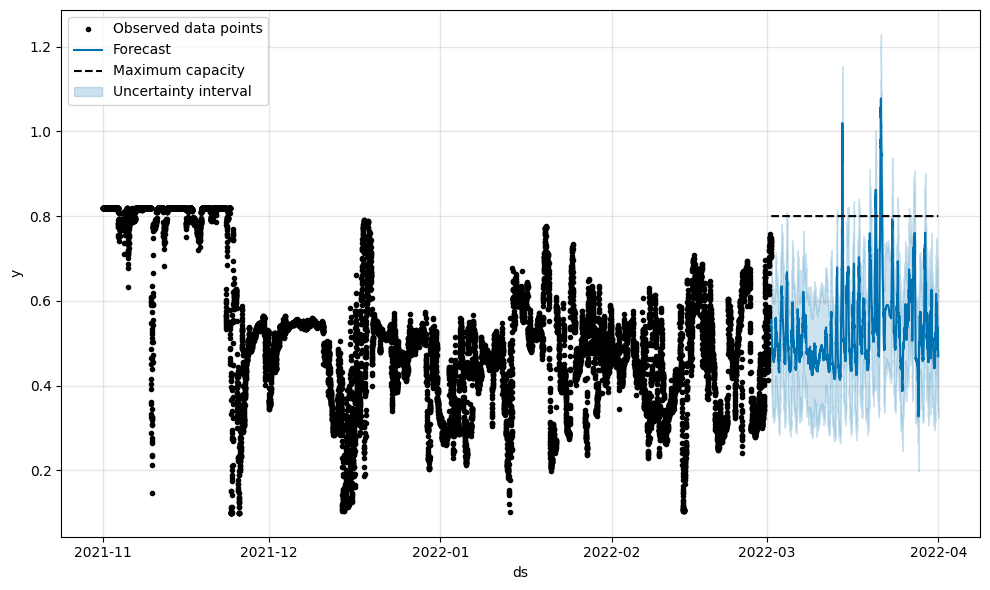

In [14]:
# Make a forecast for unseen X_test data and plot forecast
fcst = model.predict(X_test2)
fig = model.plot(fcst, include_legend=True)

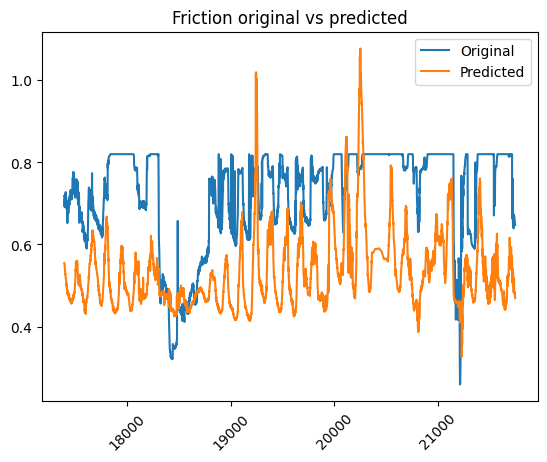

In [15]:
plt.title('Friction original vs predicted')
plt.plot(X_test.index, X_test.y, label="Original")
plt.plot(X_test.index, fcst.yhat, label="Predicted")
plt.xticks(rotation=45)
plt.legend()


In [16]:
# Test a forecast for X_train data
forecast1_train = model.predict(X_train2)
forecast1_train


,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,Road_Surface_Temperature,Road_Surface_Temperature_lower,Road_Surface_Temperature_upper,...,precipitation,precipitation_lower,precipitation_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-11-01 00:00:00,0.486732,0.8,0.725242,1.008879,0.486732,0.486732,0.019346,0.019346,0.019346,...,0.0,0.0,0.0,-0.013987,-0.013987,-0.013987,0.0,0.0,0.0,0.862235
1,2021-11-01 00:10:00,0.486702,0.8,0.735000,1.006643,0.486702,0.486702,0.019167,0.019167,0.019167,...,0.0,0.0,0.0,-0.013897,-0.013897,-0.013897,0.0,0.0,0.0,0.870777
2,2021-11-01 00:20:00,0.486672,0.8,0.733196,1.011014,0.486672,0.486672,0.018847,0.018847,0.018847,...,0.0,0.0,0.0,-0.013805,-0.013805,-0.013805,0.0,0.0,0.0,0.874688
3,2021-11-01 00:30:00,0.486642,0.8,0.743110,1.026677,0.486642,0.486642,0.019329,0.019329,0.019329,...,0.0,0.0,0.0,-0.013710,-0.013710,-0.013710,0.0,0.0,0.0,0.879669
4,2021-11-01 00:40:00,0.486612,0.8,0.749103,1.021622,0.486612,0.486612,0.018727,0.018727,0.018727,...,0.0,0.0,0.0,-0.013613,-0.013613,-0.013613,0.0,0.0,0.0,0.883606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17390,2022-03-01 18:20:00,0.100420,0.8,0.457654,0.726247,0.100420,0.100420,0.001383,0.001383,0.001383,...,0.0,0.0,0.0,0.014945,0.014945,0.014945,0.0,0.0,0.0,0.596380
17391,2022-03-01 18:30:00,0.100420,0.8,0.439956,0.734466,0.100420,0.100420,0.001697,0.001697,0.001697,...,0.0,0.0,0.0,0.014820,0.014820,0.014820,0.0,0.0,0.0,0.588556
17392,2022-03-01 18:40:00,0.100420,0.8,0.435334,0.719751,0.100420,0.100420,0.002452,0.002452,0.002452,...,0.0,0.0,0.0,0.014694,0.014694,0.014694,0.0,0.0,0.0,0.581663
17393,2022-03-01 18:50:00,0.100419,0.8,0.422242,0.711668,0.100419,0.100419,0.002630,0.002630,0.002630,...,0.0,0.0,0.0,0.014566,0.014566,0.014566,0.0,0.0,0.0,0.568608


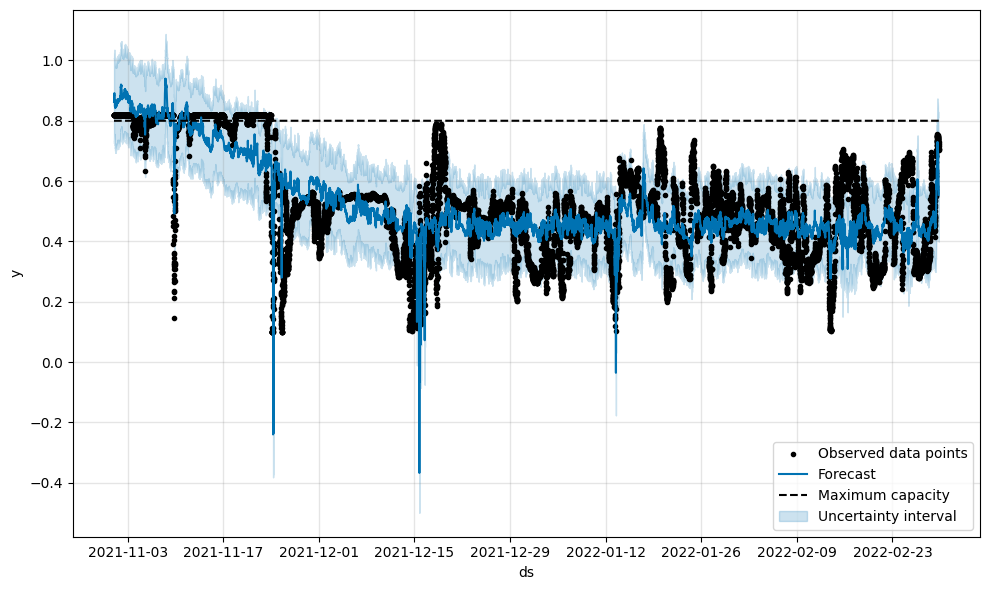

In [17]:
# Plot test forecast
fig = model.plot(forecast1_train, include_legend=True)

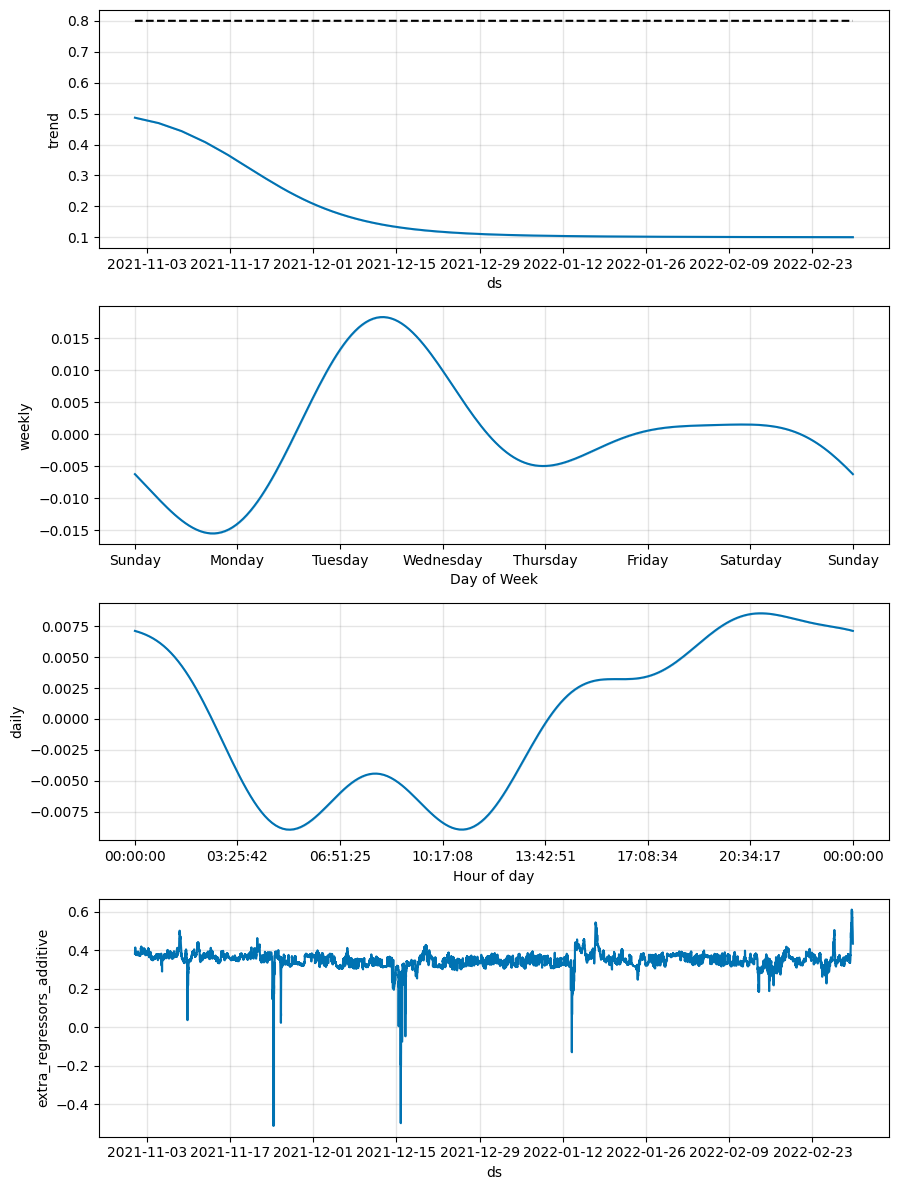

In [18]:
# plot components of test forecast
fig = model.plot_components(forecast1_train)


In [ ]:
# Run cross validation and save results into DF for further usage
# parameters:
# horizon: string with pd.Timedelta compatible style, e.g., '5 days',

# period: string with pd.Timedelta compatible style. Simulated forecast will
# be done at every this period. If not provided, 0.5 * horizon is used.

# initial: string with pd.Timedelta compatible style. The first training
# period will include at least this much data. If not provided,
# 3 * horizon is used.

# cutoffs: list of pd.Timestamp specifying cutoffs to be used during
# cross validation. If not provided, they are generated as described
# above.

# parallel : {None, 'processes', 'threads', 'dask', object}

df_cv2 = cross_validation(model, horizon='2 days',parallel='processes')


17:41:00 - cmdstanpy - INFO - Chain [1] start processing
17:41:01 - cmdstanpy - INFO - Chain [1] start processing
17:41:01 - cmdstanpy - INFO - Chain [1] start processing
17:41:01 - cmdstanpy - INFO - Chain [1] start processing
17:41:01 - cmdstanpy - INFO - Chain [1] start processing
17:41:01 - cmdstanpy - INFO - Chain [1] start processing
17:41:01 - cmdstanpy - INFO - Chain [1] start processing
17:41:01 - cmdstanpy - INFO - Chain [1] start processing
17:41:01 - cmdstanpy - INFO - Chain [1] done processing
17:41:01 - cmdstanpy - INFO - Chain [1] done processing
17:41:01 - cmdstanpy - INFO - Chain [1] done processing
17:41:01 - cmdstanpy - INFO - Chain [1] done processing
17:41:01 - cmdstanpy - INFO - Chain [1] done processing
17:41:02 - cmdstanpy - INFO - Chain [1] done processing
17:41:02 - cmdstanpy - INFO - Chain [1] done processing
17:41:02 - cmdstanpy - INFO - Chain [1] done processing
17:41:02 - cmdstanpy - INFO - Chain [1] start processing
17:41:03 - cmdstanpy - INFO - Chain [1]

In [ ]:
# Run perfomance metrics
df_p = performance_metrics(df_cv2)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 04:50:00,0.016104,0.126903,0.099890,0.245479,0.155814,0.222370,0.736435
1,0 days 05:00:00,0.016151,0.127088,0.099992,0.245577,0.154760,0.222148,0.737419
2,0 days 05:10:00,0.016068,0.126761,0.099794,0.244969,0.152983,0.221282,0.740454
3,0 days 05:20:00,0.016060,0.126728,0.099707,0.245034,0.152841,0.220939,0.742734
4,0 days 05:30:00,0.016125,0.126985,0.099780,0.245462,0.152983,0.221092,0.745337
